# Librerias

In [ ]:
import torch
from torchvision.datasets import MNIST
from tqdm.notebook import tqdm

# Downlaod MINST Dataset

In [ ]:
dataset = MNIST(root = '', download = True)

In [ ]:
type(dataset[0][1])

int

In [ ]:
len(dataset)

60000

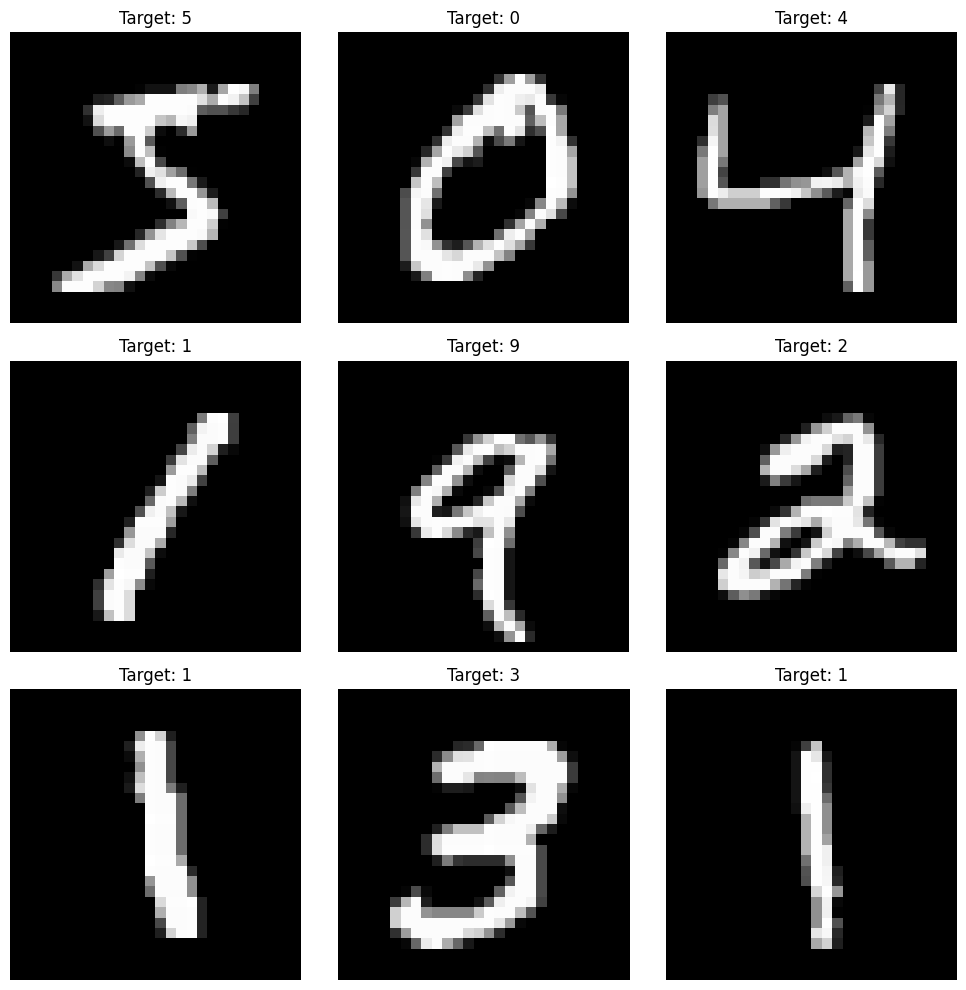

In [ ]:
import matplotlib.pyplot as plt
# Plotting
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    ax.imshow(dataset[i][0], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Target: {dataset[i][1]}')

plt.tight_layout()
plt.show()

In [ ]:
dataset[0][0].size

(28, 28)

# I need:

- Build Generator Model
  - MLP
  - CNN
- Build Discriminator Model
 - MLP
 - CNN
- Write Train routine

# Noise Dataset

In [ ]:
from torch.utils.data import Dataset
class NoiseDataset(Dataset):
  def __init__(self, latent_size):
    self.latent_size = latent_size
  def __len__(self):
    return 50000
  def __getitem__(self, idx):
    return torch.randn(self.latent_size)

In [ ]:
n_dataset = NoiseDataset(100)
n_dataset

# Generator

In [ ]:
LATENT_SIZE = 100
IMG_SIZE = 28

In [ ]:
from torch import nn

class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    # layers to use
    self.model = nn.Sequential(
        nn.Linear(LATENT_SIZE, 128),
        nn.LeakyReLU(),
        nn.Linear(128,256),
        nn.BatchNorm1d(256),
        nn.LeakyReLU(),
        nn.Linear(256, 512),
        nn.BatchNorm1d(512),
        nn.LeakyReLU(),
        nn.Linear(512, 1024),
        nn.BatchNorm1d(1024),
        nn.LeakyReLU(),
        nn.Linear(1024, IMG_SIZE*IMG_SIZE),
        nn.Tanh()
    )

  def forward(self, x):
    x = self.model(x)
    return x


In [ ]:
G = Generator()

In [ ]:
noise = torch.randn(LATENT_SIZE)

In [ ]:
G.eval()
out = G(noise.unsqueeze(0))

In [ ]:
img = out.view(IMG_SIZE, IMG_SIZE)

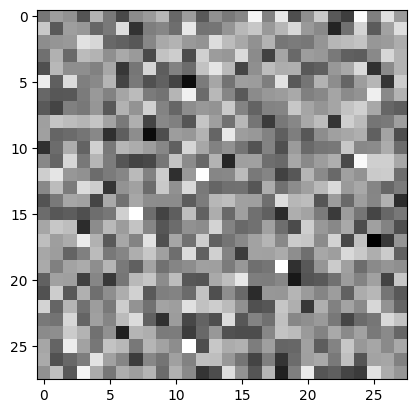

In [ ]:
plt.imshow(img.detach().numpy(), cmap='gray')

In [ ]:
G.train()

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

# Discriminator

In [ ]:
class MaxOut(nn.Module):
    def __init__(self, num_units, num_pieces):
        super(MaxOut, self).__init__()
        self.num_units = num_units
        self.num_pieces = num_pieces
        self.fc = nn.Linear(num_units, num_units * num_pieces)

    def forward(self, x):
        # Reshape the output to separate pieces
        maxout_output = self.fc(x).view(-1, self.num_pieces, self.num_units)
        # Take the maximum value across pieces
        output, _ = torch.max(maxout_output, dim=1)
        return output

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.model = nn.Sequential(
        nn.Linear(IMG_SIZE*IMG_SIZE, 512),
        MaxOut(512, 4),
        nn.Linear(512, 256),
        MaxOut(256, 4),
        #nn.Linear(512, 256),
        #MaxOut(256, 2),
        nn.Linear(256, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.model(x)
    return x

In [ ]:
D = Discriminator()

# Data

In [ ]:
from torchvision.transforms import transforms

In [ ]:

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image or numpy array to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the tensor with mean and standard deviation
])

In [ ]:
dataset = MNIST(root = '', download = True, transform =transform )

In [ ]:
from torch.utils.data import DataLoader, RandomSampler
sampler = RandomSampler(dataset)
noise_sampler = RandomSampler(n_dataset)

original_dl = DataLoader(dataset, batch_size = 64, sampler = sampler, pin_memory=torch.cuda.is_available())
noise_dl = DataLoader(n_dataset, batch_size = 64, sampler = noise_sampler, pin_memory=torch.cuda.is_available())

#original_dl = DataLoader(dataset, batch_size = 64, shuffle = True, pin_memory=torch.cuda.is_available())
#noise_dl = DataLoader(n_dataset, batch_size = 64, pin_memory=torch.cuda.is_available())

# Training

In [ ]:
EPOCHS = 20000
K = 1
BATCH_SIZE = 64
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
D_LOSS = nn.BCELoss()
G_LOSS = nn.BCELoss()#weight = torch.full((BATCH_SIZE, 1), -1).to(device))

In [ ]:
d_optimizer = torch.optim.Adam(D.parameters(), lr = 0.0002, betas = (0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr = 0.0002, betas = (0.5, 0.999))

In [ ]:
K_g = int(len(dataset)/BATCH_SIZE)

In [ ]:
device

'cuda'

In [ ]:
G.to(device)
D.to(device)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): MaxOut(
      (fc): Linear(in_features=512, out_features=2048, bias=True)
    )
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): MaxOut(
      (fc): Linear(in_features=256, out_features=1024, bias=True)
    )
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

# Prueba 1

In [ ]:
g_losses = []
d_losses = []

fix_sample = n_dataset[0] # Fix sample to observation

for epoch in tqdm(range(EPOCHS)):
  for k in range(K):
    # Discriminator Optimization
    for i, batch in enumerate(original_dl):
      #x, _ = next(iter(original_dl)) # random batch
      x, _ = batch
      x = x.to(device)
      batch_size = x.size()[0]
      x_b = x.view(batch_size, -1)
      d_optimizer.zero_grad()

      # models outputs
      #z = noise.repeat(batch_size, 1)
      #z = next(iter(noise_dl))
      z = torch.randn((x_b.shape[0], 100))
      z = z.to(device)
      G_z = G(z)
      D_x  = D(x_b)
      D_G_z = D(G_z)


      # tensor
      #samples = torch.cat([D_G_z, D_x]).to(device)
      #targets = torch.cat([torch.zeros(D_G_z.size()[0]), torch.ones(D_x.size()[0])]).to(device)

      true_loss = D_LOSS(D_x,  torch.ones((D_x.size()[0],1)).to(device))
      fake_loss = D_LOSS(D_G_z,  torch.zeros((D_G_z.size()[0],1)).to(device))
      d_loss = (true_loss + fake_loss)/2

      # Generate a random permutation
      #permutation = torch.randperm(samples.size()[0])
      #samples = samples[permutation]
      #targets = targets[permutation]

      # loss
      #d_loss = D_LOSS(samples, targets.unsqueeze(-1))
      d_loss.backward()

      # Adjust learning weights
      d_optimizer.step()

  # Generator Optimization
  #for i, batch in enumerate(noise_dl):
  for i in range(K_g):

    g_optimizer.zero_grad()
    #z = batch.to(device)
    z = torch.randn((x_b.shape[0], 100)).to(device)
    G_z = G(z)
    D_G_z = D(G_z)
    targets = torch.ones(D_G_z.size()[0])
    #G_LOSS = nn.BCELoss(weight = torch.full((D_G_z.size()[0], 1), -1).to(device))
    g_loss = G_LOSS(D_G_z.to(device), targets.unsqueeze(-1).to(device))
    g_loss.backward()

    # Adjust learning weights
    g_optimizer.step()

  if epoch%10 == 0:
    print(f"Discriminator Loss Epoch {epoch}: {d_loss}")
    print(f"Generator Loss Epoch {epoch}: {g_loss}")
    #G.eval()
    #fig = plt.Figure(figsize=(10, 10))
    #plt.imshow(G(fix_sample.unsqueeze(0).to(device)).to("cpu").view(IMG_SIZE, IMG_SIZE).detach().numpy(), cmap='gray')
    #plt.show()
    #G.train()



  g_losses.append(g_loss.item())
  d_losses.append(d_loss.item())









  0%|          | 0/200 [00:00<?, ?it/s]

Discriminator Loss Epoch 0: 4.0500680142940837e-07
Generator Loss Epoch 0: 0.0001620517432456836
Discriminator Loss Epoch 10: 2.5190569431288168e-05
Generator Loss Epoch 10: 0.00016735546523705125
Discriminator Loss Epoch 20: 2.4156612198567018e-05
Generator Loss Epoch 20: 4.772125976160169e-06
Discriminator Loss Epoch 30: 50.0
Generator Loss Epoch 30: 2.569617509841919
Discriminator Loss Epoch 40: 50.0
Generator Loss Epoch 40: 100.0
Discriminator Loss Epoch 50: 50.0
Generator Loss Epoch 50: 100.0
Discriminator Loss Epoch 60: 50.0
Generator Loss Epoch 60: 100.0
Discriminator Loss Epoch 70: 50.0
Generator Loss Epoch 70: 100.0


KeyboardInterrupt: 

In [ ]:
x_b.shape[0]

64

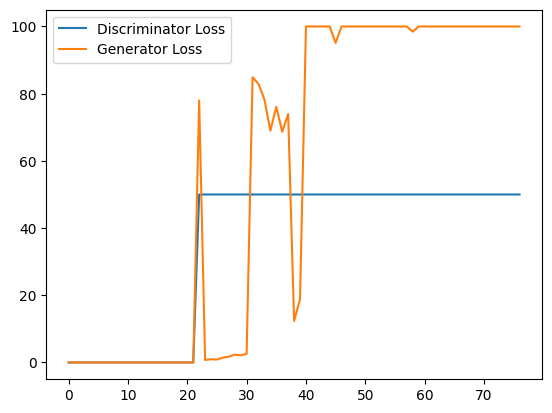

In [ ]:
plt.plot(range(epoch), d_losses)
plt.plot(range(epoch), g_losses)
plt.legend(['Discriminator Loss', 'Generator Loss'])

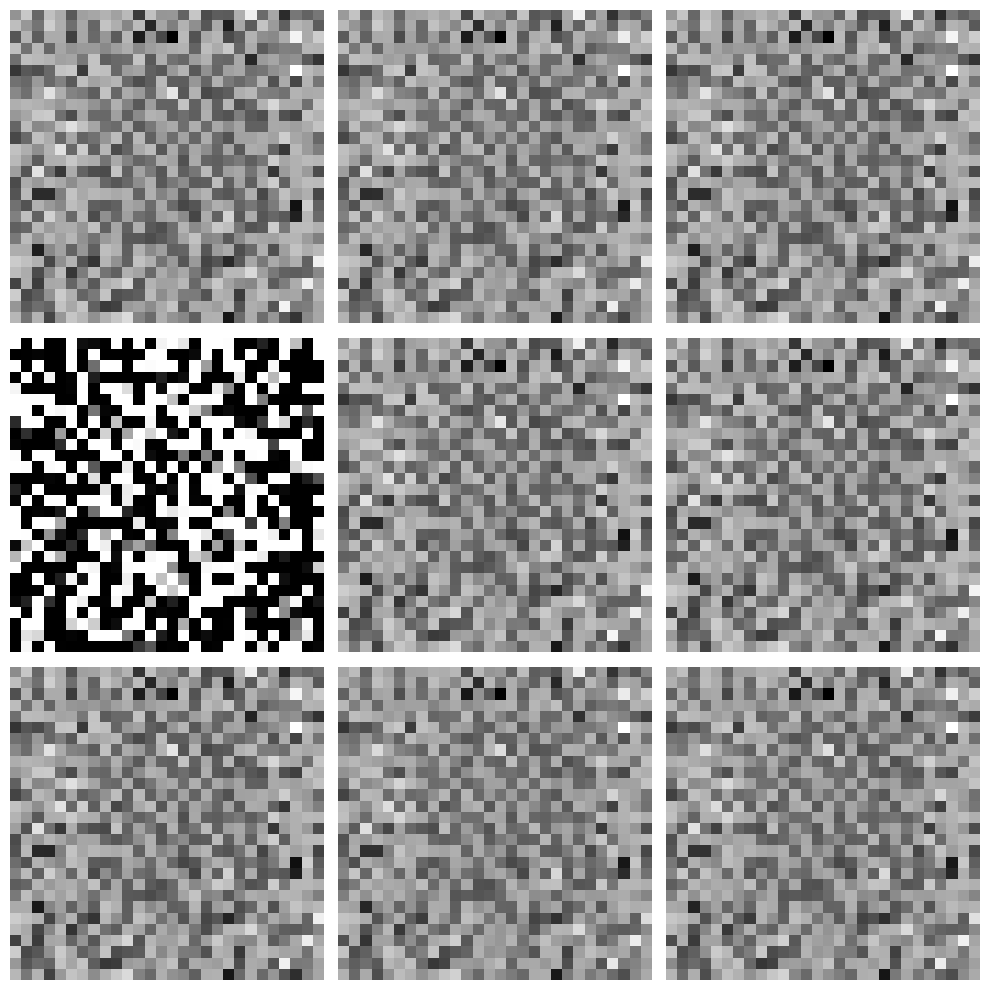

In [ ]:
G.eval()
import matplotlib.pyplot as plt
# Plotting
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    ax.imshow(G(n_dataset[i].unsqueeze(0).to(device)).to("cpu").view(IMG_SIZE, IMG_SIZE).detach().numpy(), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
z[0]

tensor([ 2.0347,  0.2043, -0.8349,  0.1367,  1.2520, -0.2544, -0.0966,  1.1256,
        -1.0931,  0.6958,  1.1130,  0.4549, -0.1479, -0.9276, -0.5851,  0.3797,
        -0.3275,  0.8582,  0.5975, -0.3620, -0.9356,  0.4939, -1.2286,  0.1805,
        -2.2370, -0.4648,  1.8948,  0.7082,  1.7272, -0.9131, -0.4266, -0.3149,
         0.1222, -1.6391, -0.7033,  0.4451,  0.3157, -1.0055, -0.0603,  1.1686,
         2.8435, -0.0189,  1.8370,  0.4752,  0.7107,  1.7987,  0.4651, -0.2957,
         2.3779,  0.1726,  0.6568,  0.3886, -2.4166,  0.9717, -0.7752, -1.5437,
         2.0831, -0.8636,  0.8278,  0.1356, -1.5115, -0.8421,  0.5505,  0.9195,
        -0.6788, -1.5689,  0.7966, -0.3141, -0.2838, -0.3674,  2.0697,  0.1383,
        -0.6242, -0.5590,  0.3618,  1.3812,  0.0243, -0.4996,  1.6013, -1.9471,
        -1.7950,  0.6781, -0.2893,  0.4733, -0.7219, -0.7937, -0.1002, -1.1932,
         1.4029,  0.3289, -2.2372, -1.0100, -0.3962, -0.8218, -0.8740, -0.3847,
        -1.1570,  1.7894,  0.9082, -0.36

In [ ]:
z[1]

tensor([ 0.9445,  1.4705, -0.5739, -1.6313,  0.8667, -0.7533, -0.9756,  0.7840,
         1.6554, -1.3688, -0.1673, -0.1345, -0.4835,  0.2612,  0.5545,  0.8967,
        -0.1139, -2.0420, -2.3868, -1.5678,  0.5512, -0.0984,  0.1898,  0.8290,
         0.6636,  0.6689,  0.1497, -0.2439,  0.3669,  0.9592, -0.4469,  0.2035,
         1.5272, -0.2767, -0.2014, -0.5328,  1.2653, -0.1810, -1.4276,  0.2163,
        -1.3630,  1.0401, -0.6888,  0.9490,  1.4722, -0.6268, -0.2714,  0.3344,
         0.7687, -0.4259, -1.0599,  1.7718,  0.1974,  0.5976,  2.9614,  0.1333,
        -0.9356, -0.4706,  0.4022, -0.6966,  0.5166, -0.7084,  0.4832, -1.5721,
         0.9089,  0.2076,  0.0189, -1.3405,  0.1679, -0.0082, -0.0798,  0.4650,
        -0.6319,  1.3114, -0.3246,  0.3940,  0.1682,  0.2904,  0.3749, -1.2844,
         1.5715, -0.0571, -0.0654,  1.6254, -0.5089,  1.8423, -0.8923,  0.5729,
         0.6799,  1.6958, -0.1223, -0.0917,  0.0255, -0.0274,  0.7578,  0.1464,
        -0.3468, -0.7187, -0.4183,  1.15

In [ ]:
D_G_z

tensor([[1.4191e-03],
        [9.1881e-06],
        [4.3039e-05],
        [2.0001e-06],
        [8.8589e-03],
        [3.7546e-02],
        [2.0607e-06],
        [1.8535e-03],
        [7.6657e-05],
        [5.0666e-05],
        [1.3991e-03],
        [2.4203e-06],
        [3.4645e-03],
        [1.3756e-04],
        [1.4656e-04],
        [3.1957e-04],
        [9.5951e-03],
        [3.2595e-03],
        [1.4156e-02],
        [2.7483e-05],
        [2.2586e-04],
        [4.8292e-06],
        [7.6447e-05],
        [1.6159e-03],
        [5.6148e-04],
        [8.9279e-05],
        [4.0847e-04],
        [6.5618e-04],
        [1.2602e-04],
        [1.1309e-03],
        [1.4057e-02],
        [6.1811e-04],
        [1.9843e-03],
        [1.4257e-03],
        [5.4121e-04],
        [1.6436e-04],
        [2.2783e-02],
        [1.9531e-03],
        [6.0208e-04],
        [9.8340e-04],
        [5.0936e-04],
        [5.8824e-06],
        [8.7138e-06],
        [3.8868e-04],
        [1.1297e-03],
        [4

# Prueba 2

In [ ]:
g_losses = []
d_losses = []

fix_sample = n_dataset[0] # Fix sample to observation

for epoch in tqdm(range(EPOCHS)):
  for k in range(K):
    # Discriminator Optimization
    x, _ = next(iter(original_dl)) # random batch
    #x, _ = batch
    x = x.to(device)
    batch_size = x.size()[0]
    x_b = x.view(batch_size, -1)
    d_optimizer.zero_grad()

    # models outputs
    #z = noise.repeat(batch_size, 1)
    z = next(iter(noise_dl))
    z = z.to(device)
    G_z = G(z)
    D_x  = D(x_b)
    D_G_z = D(G_z)


    # tensor
    samples = torch.cat([D_G_z, D_x]).to(device)
    targets = torch.cat([torch.zeros(D_G_z.size()[0]), torch.ones(D_x.size()[0])]).to(device)
    # Generate a random permutation
    #permutation = torch.randperm(samples.size()[0])
    #samples = samples[permutation]
    #targets = targets[permutation]

    # loss
    d_loss = D_LOSS(samples, targets.unsqueeze(-1))
    d_loss.backward()

    # Adjust learning weights
    d_optimizer.step()

  # Generator Optimization
  g_optimizer.zero_grad()
  z = next(iter(noise_dl)).to(device)
  G_z = G(z)
  D_G_z = D(G_z)
  targets = torch.zeros(D_G_z.size()[0])
  #G_LOSS = nn.BCELoss(weight = torch.full((D_G_z.size()[0], 1), -1).to(device))
  g_loss = -G_LOSS(D_G_z.to(device), targets.unsqueeze(-1).to(device))
  g_loss.backward()

  # Adjust learning weights
  g_optimizer.step()

  if epoch%1000 == 0:
    print(f"Discriminator Loss Epoch {epoch}: {d_loss}")
    print(f"Generator Loss Epoch {epoch}: {g_loss}")
    torch.save(G.state_dict(), f"checkpoint_{epoch}.pt")
    #G.eval()
    #fig = plt.Figure(figsize=(10, 10))
    #plt.imshow(G(fix_sample.unsqueeze(0).to(device)).to("cpu").view(IMG_SIZE, IMG_SIZE).detach().numpy(), cmap='gray')
    #plt.show()
    #G.train()



  g_losses.append(g_loss.item())
  d_losses.append(d_loss.item())









  0%|          | 0/20000 [00:00<?, ?it/s]

Discriminator Loss Epoch 0: 0.674328088760376
Generator Loss Epoch 0: -0.6753689050674438
Discriminator Loss Epoch 1000: 0.27845245599746704
Generator Loss Epoch 1000: -0.3063308596611023
Discriminator Loss Epoch 2000: 0.5289125442504883
Generator Loss Epoch 2000: -1.3166756629943848
Discriminator Loss Epoch 3000: 0.668877124786377
Generator Loss Epoch 3000: -0.07213252782821655
Discriminator Loss Epoch 4000: 0.5403763651847839
Generator Loss Epoch 4000: -0.22692877054214478
Discriminator Loss Epoch 5000: 0.48897019028663635
Generator Loss Epoch 5000: -0.7318536639213562
Discriminator Loss Epoch 6000: 0.5189499258995056
Generator Loss Epoch 6000: -0.7572990655899048
Discriminator Loss Epoch 7000: 0.5059046745300293
Generator Loss Epoch 7000: -0.6032814979553223
Discriminator Loss Epoch 8000: 0.5098813772201538
Generator Loss Epoch 8000: -0.6391043663024902
Discriminator Loss Epoch 9000: 0.5325431823730469
Generator Loss Epoch 9000: -0.4667496681213379
Discriminator Loss Epoch 10000: 0.

In [ ]:
targets.shape

torch.Size([64])

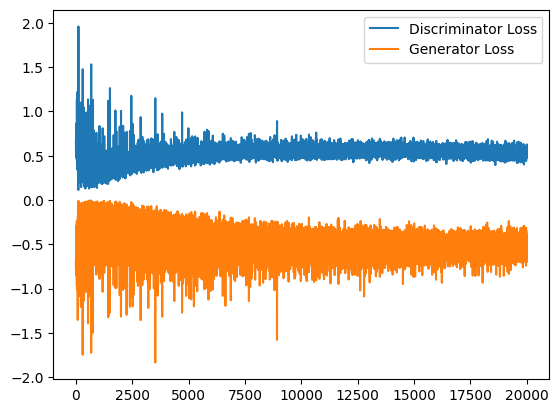

In [ ]:
plt.plot(range(EPOCHS), d_losses)
plt.plot(range(EPOCHS), g_losses)
plt.legend(['Discriminator Loss', 'Generator Loss'])

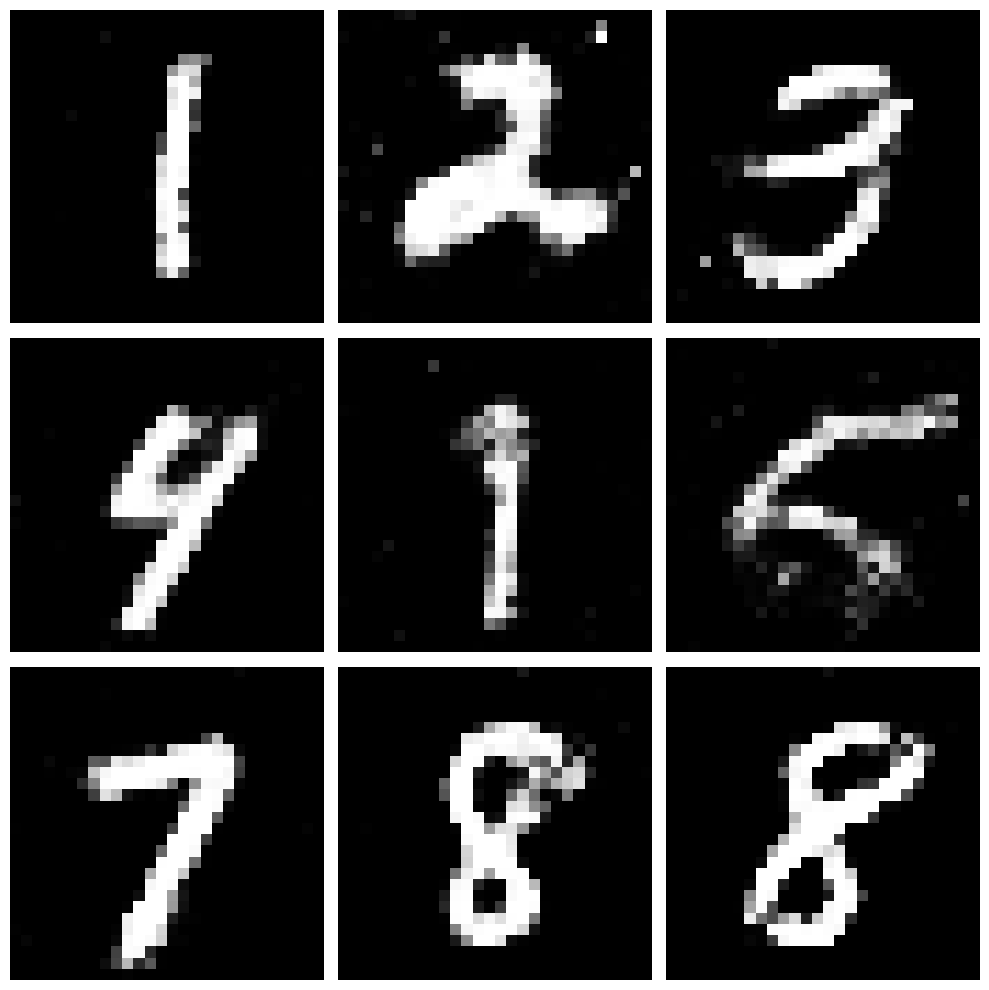

In [ ]:
G.eval()
import matplotlib.pyplot as plt
# Plotting
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    ax.imshow(G(n_dataset[i].unsqueeze(0).to(device)).to("cpu").view(IMG_SIZE, IMG_SIZE).detach().numpy(), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import glob
checkpoints = glob.glob("*.pt")
def sort_key(checkpoint):
    return int(checkpoint.split('_')[1].split('.')[0])
# Sort the checkpoint list using the custom sorting function
sorted_checkpoints = sorted(checkpoints, key=sort_key)
sorted_checkpoints

['checkpoint_0.pt',
 'checkpoint_1000.pt',
 'checkpoint_2000.pt',
 'checkpoint_3000.pt',
 'checkpoint_4000.pt',
 'checkpoint_5000.pt',
 'checkpoint_6000.pt',
 'checkpoint_7000.pt',
 'checkpoint_8000.pt',
 'checkpoint_9000.pt',
 'checkpoint_10000.pt',
 'checkpoint_11000.pt',
 'checkpoint_12000.pt',
 'checkpoint_13000.pt',
 'checkpoint_14000.pt',
 'checkpoint_15000.pt',
 'checkpoint_16000.pt',
 'checkpoint_17000.pt',
 'checkpoint_18000.pt',
 'checkpoint_19000.pt']

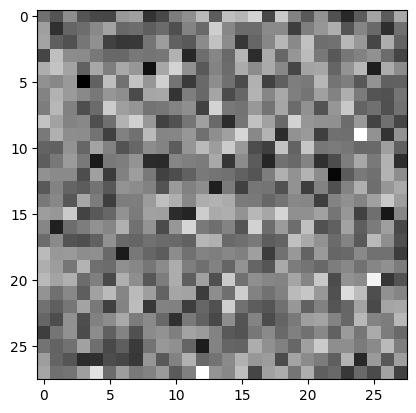

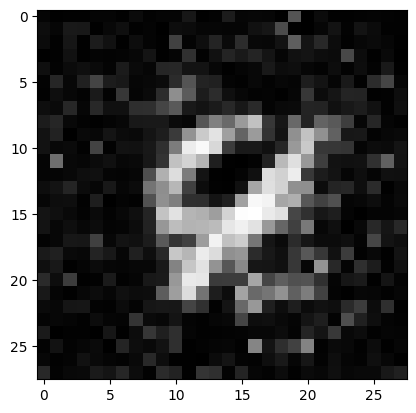

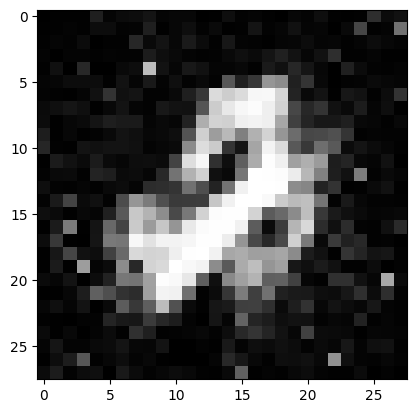

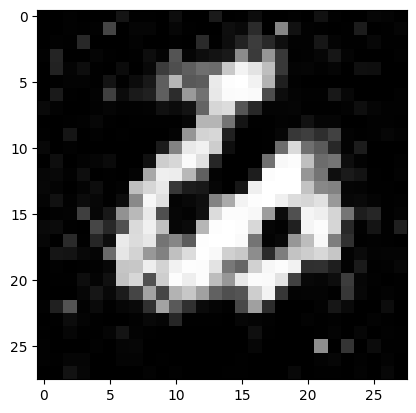

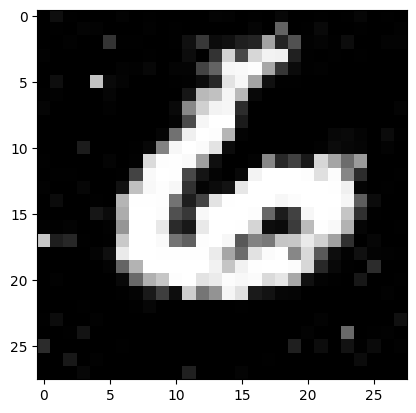

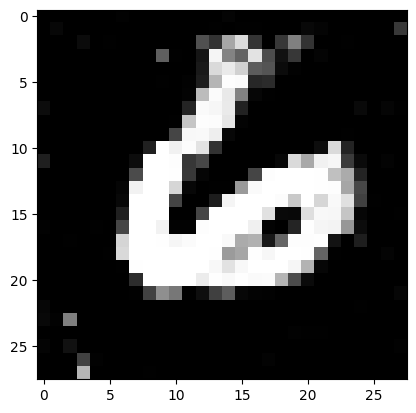

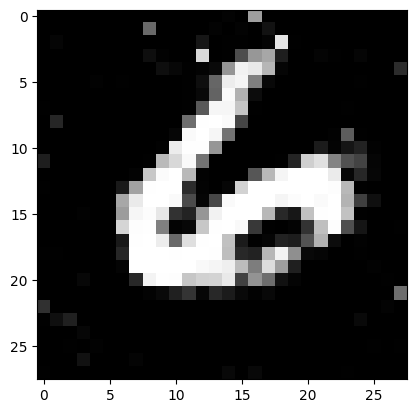

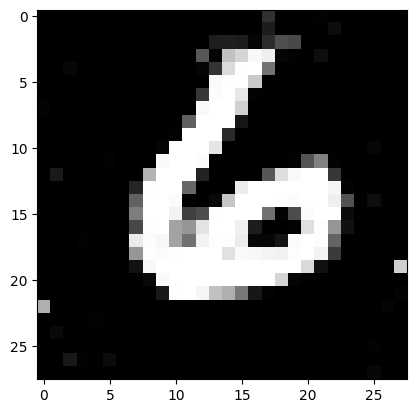

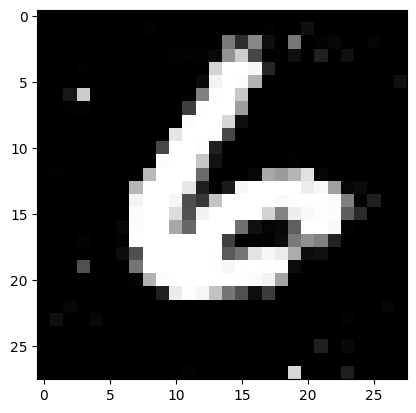

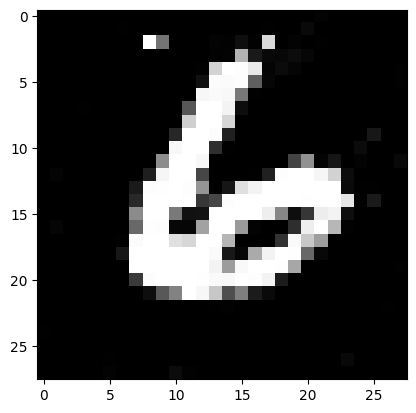

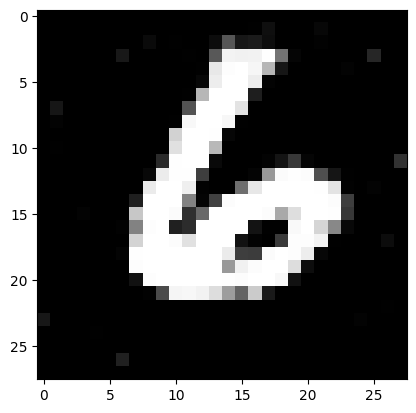

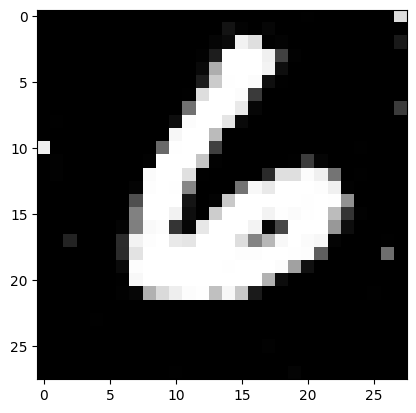

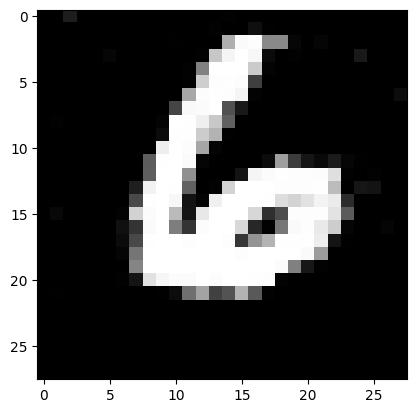

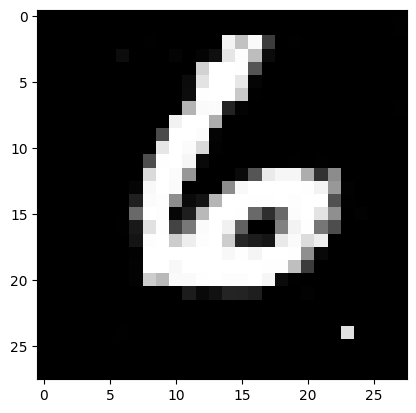

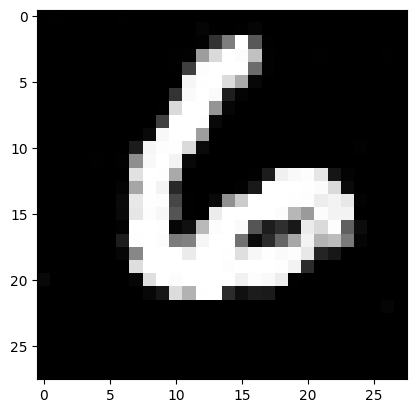

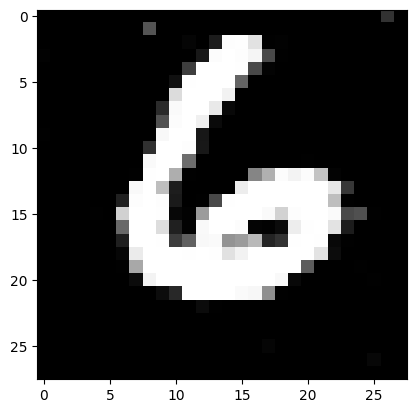

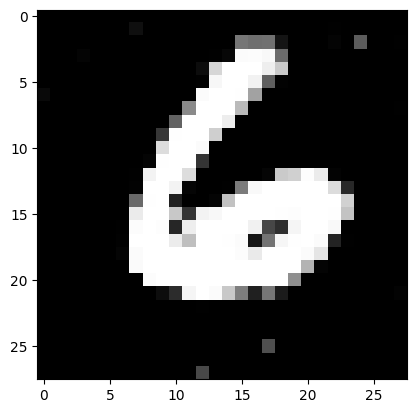

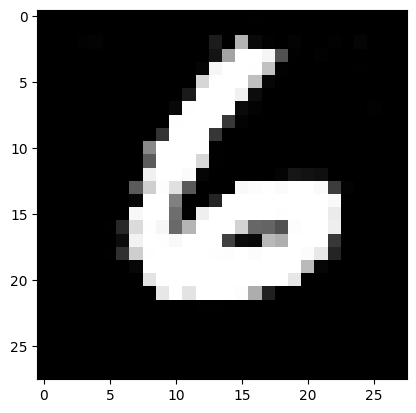

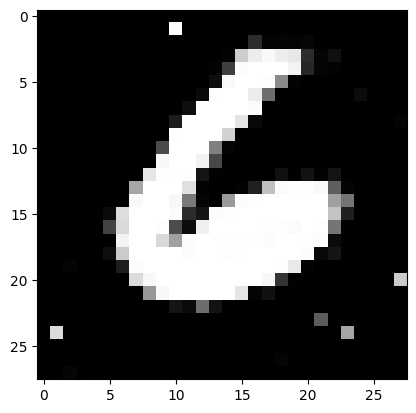

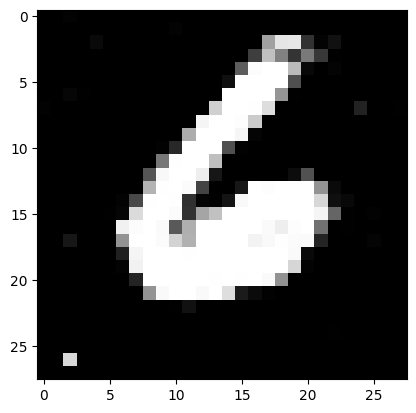

In [ ]:
fix_sample = n_dataset[0]
for cp in sorted_checkpoints:
  model = Generator()
  model.load_state_dict(torch.load(cp))
  model.eval()
  img = model(fix_sample.unsqueeze(0))
  plt.imshow(img.view(IMG_SIZE, IMG_SIZE).detach().numpy(), cmap = 'gray')
  ax.axis('off')
  plt.show()

In [ ]:
fix_sample.shape

torch.Size([100])

In [ ]:
img

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9988,
         -1.0000, -1.0000, -1.0000, -0.9997, -1.0000, -0.9993, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -0.9646, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -0.9728, -1.0000, -1.0000, -1.0000, -0.9999, -1.0000, -1.0000,
         -0.9998, -0.9999, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -0.9980, -1.0000, -1.0000, -1.0000, -0.9999, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -0.9996, -1.0000, -1.0000, -0.9999, -1.0000,
         -1.0000, -1.0000, -1.0000, -0.9996, -1.0000, -1.0000, -1.0000, -0.9997,
         -0.9974, -1.0000, -0.9999, -0.9911, -0.9607, -0.9925, -0.9999, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9592, -0.9939, -1.0000,
         -1.0000, -1.0000, -1.0000, -0.9998, -1.0000, -0.9229, -0.9978, -1.0000,
         -1.0000, -0.9964, -1.0000, -1.0000, -1.0000, -1.0000, -0.9999, -0.9993,
         -1.0000, -1.0000, -